## Analisis Data Segmentasi Nasabah Bank

In [60]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

### Exploratory Data Analysis (EDA)

#### Inspeksi Awal Data

In [61]:
df = pd.read_csv('bank_transactions.csv')
df = df.sample(frac=0.01, random_state=42)

df.info()
print(df.describe())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 10486 entries, 892845 to 658251
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            10486 non-null  object 
 1   CustomerID               10486 non-null  object 
 2   CustomerDOB              10452 non-null  object 
 3   CustGender               10477 non-null  object 
 4   CustLocation             10486 non-null  object 
 5   CustAccountBalance       10466 non-null  float64
 6   TransactionDate          10486 non-null  object 
 7   TransactionTime          10486 non-null  int64  
 8   TransactionAmount (INR)  10486 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 819.2+ KB
       CustAccountBalance  TransactionTime  TransactionAmount (INR)
count        1.046600e+04     10486.000000             10486.000000
mean         1.012919e+05    156735.529086              1648.626688
std          3.988455e+05    

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
892845,T892846,C5725279,8/9/84,M,JASPUR,84447.82,7/9/16,183210,11858.00
444994,T444995,C4588538,2/1/94,M,GURGAON,12549.49,16/8/16,161300,250.00
614896,T614897,C2416476,14/11/90,M,NEW DELHI,33607.65,26/8/16,102007,3360.00
457036,T457037,C5940151,15/9/90,M,HYDERABAD,38238.86,21/8/16,110438,250.00
997441,T997442,C5922989,27/11/88,M,PURBO MEDINIPUR,9506.85,14/9/16,90810,33.00
518219,T518220,C8296884,31/10/89,M,BANGALORE,635863.63,19/8/16,215646,2688.00
778232,T778233,C6671851,1/1/1800,M,SHOPPING COMPLEX THIRUVANATHAPURAM,5867.38,6/9/16,193036,870.00
151835,T151836,C8927812,3/3/87,M,NEW DELHI,63911.56,4/8/16,30857,499.00
446575,T446576,C7511745,23/3/92,F,GURGAON,19853.15,16/8/16,183906,280.00
887527,T887528,C6126877,1/10/93,M,GURGAON,3848.86,7/9/16,201500,203.45


 #### Penanganan Missing Values dan Cek Outlier

Sebelum Penanganan Missing Values: 
TransactionID               0
CustomerID                  0
CustomerDOB                34
CustGender                  9
CustLocation                0
CustAccountBalance         20
TransactionDate             0
TransactionTime             0
TransactionAmount (INR)     0
dtype: int64
Setelah Penanganan Missing Values: 
TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64


<Axes: >

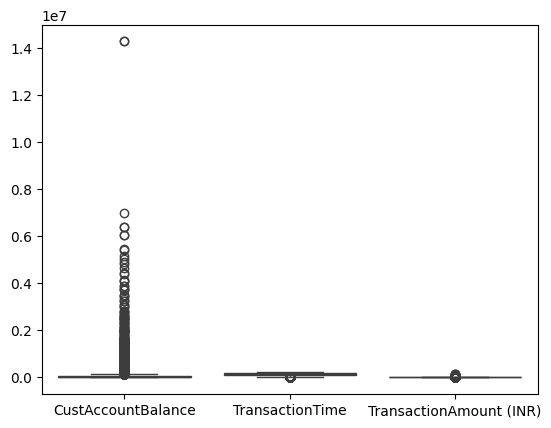

In [62]:

print("Sebelum Penanganan Missing Values: ")
print(df.isnull().sum())

print("Setelah Penanganan Missing Values: ")
df = df.dropna()
print(df.isnull().sum())

import seaborn as sns
sns.boxplot(df)

### Analisis Univariat

<Figure size 1200x500 with 0 Axes>

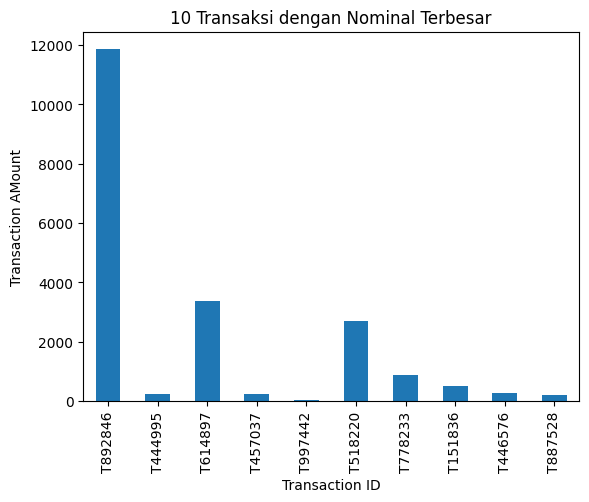

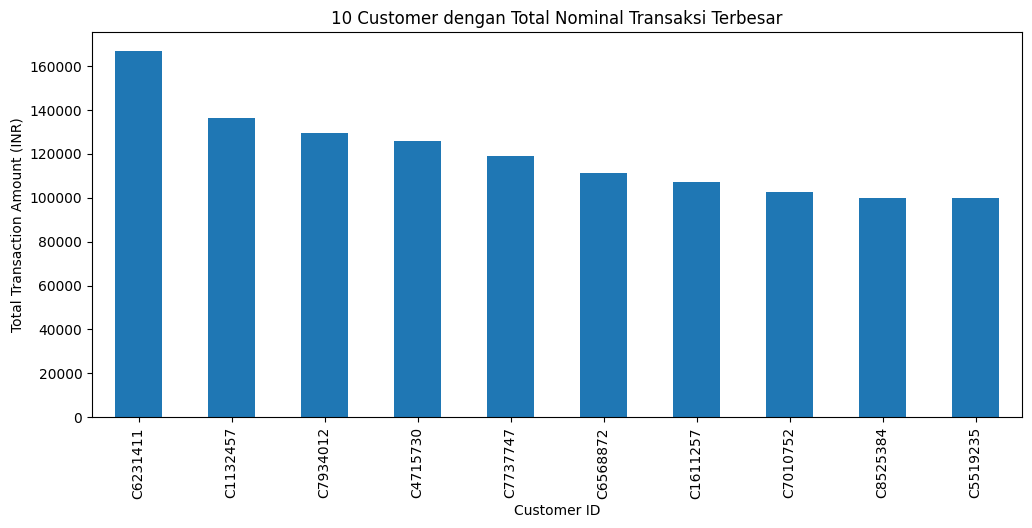

In [63]:
plt.figure(figsize=(12,5))
df.head(10).plot(
    x="TransactionID",
    y="TransactionAmount (INR)",
    kind='bar',
    legend=False
)
plt.title('10 Transaksi dengan Nominal Terbesar')
plt.xlabel('Transaction ID')
plt.ylabel('Transaction AMount')
plt.show()

customer_sum = df.groupby('CustomerID')['TransactionAmount (INR)'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12,5))
customer_sum.plot(kind='bar')

plt.title('10 Customer dengan Total Nominal Transaksi Terbesar')
plt.xlabel('Customer ID')
plt.ylabel('Total Transaction Amount (INR)')
plt.show()

### Data Processing

In [64]:
df_agg = df.groupby('CustomerID').agg(
    Jumlah_Transaksi=('TransactionID', 'count'),
    Total_Amount=('TransactionAmount (INR)', 'sum'),
    Avg_Amount=('TransactionAmount (INR)', 'mean'),
    Max_Amount=('TransactionAmount (INR)', 'max'),
    Mean_AccountBalance=('CustAccountBalance', 'mean'),
    CustGender=('CustGender', 'first'),
    CustLocation=('CustLocation', 'first'),
    CustomerDOB=('CustomerDOB', 'first')
).reset_index()


#### Standarisasi Fitur Numerik

In [65]:
# Konversi Date of Birth (DOB) ke Umur
df_agg['CustomerDOB'] = pd.to_datetime(df_agg['CustomerDOB'], format='%d/%m/%y', errors='coerce')
# print(df['CustomerDOB'].dt.year.value_counts().sort_index())
df_agg.loc[df_agg['CustomerDOB'].dt.year > 2025, 'CustomerDOB'] = df_agg['CustomerDOB'] - pd.DateOffset(years=100)
df_agg['CustomerDOB'].head(10)
today = pd.Timestamp.now()
df_agg['Umur'] = (today - df_agg['CustomerDOB']).dt.days // 365
df_agg = df_agg.dropna()
print(df_agg['Umur'].isna().sum())
df_agg['Umur'] = df_agg['Umur'].astype(int)
print(df_agg[['CustomerID','Umur']].head(10))
# df_agg.drop(df_agg['CustomerDOB'])

# Konversi Gender Male dan Female ke 0 dan 1
df_agg['CustGender'] = df_agg['CustGender'].map({'M': 1, 'F': 0})
df_agg.head(10)


0
   CustomerID  Umur
0    C1010243    45
1    C1010655    34
2    C1010666    42
4    C1010923    39
5    C1011343    38
6    C1011678    43
7    C1011728    75
8    C1011744    32
9    C1012179    38
10   C1012572    34


,CustomerID,Jumlah_Transaksi,Total_Amount,Avg_Amount,Max_Amount,Mean_AccountBalance,CustGender,CustLocation,CustomerDOB,Umur
0,C1010243,1,253.0,253.0,253.0,149425.48,1,TEHRI GARHWAL,1980-03-01,45
1,C1010655,1,712.0,712.0,712.0,45856.24,1,MEERUT,1991-08-06,34
2,C1010666,1,497.0,497.0,497.0,4450.94,1,NANDURBAR,1983-06-06,42
4,C1010923,1,117.0,117.0,117.0,16748.07,0,BANGALORE,1986-04-11,39
5,C1011343,1,420.0,420.0,420.0,347090.85,1,NEW DELHI,1987-01-23,38
6,C1011678,1,270.0,270.0,270.0,13742.77,1,KOLKATA,1982-06-07,43
7,C1011728,1,958.0,958.0,958.0,29100.95,1,DELHI,1950-10-12,75
8,C1011744,1,937.0,937.0,937.0,15647.56,1,DELHI,1992-11-07,32
9,C1012179,1,9031.0,9031.0,9031.0,95998.72,1,LUDHIANA,1987-05-10,38
10,C1012572,1,270.0,270.0,270.0,3340.73,1,MUMBAI,1991-06-09,34


#### Scaling Data

In [66]:

# Scaling Data
num_cols = ['Jumlah_Transaksi','Total_Amount','Avg_Amount',
            'Max_Amount','Mean_AccountBalance','CustGender',
            'Umur']

scaler = StandardScaler()
df_agg[num_cols] = scaler.fit_transform(df_agg[num_cols])
df_agg.head(10)


,CustomerID,Jumlah_Transaksi,Total_Amount,Avg_Amount,Max_Amount,Mean_AccountBalance,CustGender,CustLocation,CustomerDOB,Umur
0,C1010243,-0.039337,-0.217351,-0.217017,-0.217228,0.153167,0.602031,TEHRI GARHWAL,1980-03-01,0.557784
1,C1010655,-0.039337,-0.137853,-0.137466,-0.137728,-0.128242,0.602031,MEERUT,1991-08-06,-0.687300
2,C1010666,-0.039337,-0.175091,-0.174728,-0.174966,-0.240745,0.602031,NANDURBAR,1983-06-06,0.218216
4,C1010923,-0.039337,-0.240906,-0.240587,-0.240783,-0.207332,-1.661044,BANGALORE,1986-04-11,-0.121352
5,C1011343,-0.039337,-0.188427,-0.188073,-0.188303,0.690245,0.602031,NEW DELHI,1987-01-23,-0.234542
6,C1011678,-0.039337,-0.214407,-0.214070,-0.214283,-0.215498,0.602031,KOLKATA,1982-06-07,0.331405
7,C1011728,-0.039337,-0.095247,-0.094831,-0.095120,-0.173768,0.602031,DELHI,1950-10-12,3.953469
8,C1011744,-0.039337,-0.098884,-0.098470,-0.098757,-0.210322,0.602031,DELHI,1992-11-07,-0.913679
9,C1012179,-0.039337,1.302976,1.304328,1.303146,0.008001,0.602031,LUDHIANA,1987-05-10,-0.234542
10,C1012572,-0.039337,-0.214407,-0.214070,-0.214283,-0.243761,0.602031,MUMBAI,1991-06-09,-0.687300


#### Encoding Data Column 'CustLocation'

In [67]:
# Encoding kolom kategorical dari Customer Location
top_locations = df_agg['CustLocation'].value_counts().head(100).index
df_agg['CustLocation_reduced'] = df_agg['CustLocation'].apply(lambda x: x if x in top_locations else 'Other')

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
encoded_sparse = encoder.fit_transform(df_agg[['CustLocation_reduced']])
encoded_df = pd.DataFrame.sparse.from_spmatrix(encoded_sparse, columns=encoder.get_feature_names_out(['CustLocation_reduced']))
df_agg = pd.concat([df_agg.drop(columns=['CustLocation_reduced']).reset_index(drop=True), encoded_df], axis=1)

df_agg.info()
df_agg.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9845 entries, 0 to 9844
Columns: 111 entries, CustomerID to CustLocation_reduced_ZIRAKPUR
dtypes: Sparse[float64, 0](101), datetime64[ns](1), float64(7), object(2)
memory usage: 884.6+ KB


,CustomerID,Jumlah_Transaksi,Total_Amount,Avg_Amount,Max_Amount,Mean_AccountBalance,CustGender,CustLocation,CustomerDOB,Umur,...,CustLocation_reduced_THANE WEST,CustLocation_reduced_UDAIPUR,CustLocation_reduced_UJJAIN,CustLocation_reduced_VADODARA,CustLocation_reduced_VAPI,CustLocation_reduced_VARANASI,CustLocation_reduced_VIJAYAWADA,CustLocation_reduced_VISAKHAPATNAM,CustLocation_reduced_WARANGAL,CustLocation_reduced_ZIRAKPUR
0,C1010243,-0.039337,-0.217351,-0.217017,-0.217228,0.153167,0.602031,TEHRI GARHWAL,1980-03-01,0.557784,...,0,0,0,0,0,0,0,0,0,0
1,C1010655,-0.039337,-0.137853,-0.137466,-0.137728,-0.128242,0.602031,MEERUT,1991-08-06,-0.687300,...,0,0,0,0,0,0,0,0,0,0
2,C1010666,-0.039337,-0.175091,-0.174728,-0.174966,-0.240745,0.602031,NANDURBAR,1983-06-06,0.218216,...,0,0,0,0,0,0,0,0,0,0
3,C1010923,-0.039337,-0.240906,-0.240587,-0.240783,-0.207332,-1.661044,BANGALORE,1986-04-11,-0.121352,...,0,0,0,0,0,0,0,0,0,0
4,C1011343,-0.039337,-0.188427,-0.188073,-0.188303,0.690245,0.602031,NEW DELHI,1987-01-23,-0.234542,...,0,0,0,0,0,0,0,0,0,0
5,C1011678,-0.039337,-0.214407,-0.214070,-0.214283,-0.215498,0.602031,KOLKATA,1982-06-07,0.331405,...,0,0,0,0,0,0,0,0,0,0
6,C1011728,-0.039337,-0.095247,-0.094831,-0.095120,-0.173768,0.602031,DELHI,1950-10-12,3.953469,...,0,0,0,0,0,0,0,0,0,0
7,C1011744,-0.039337,-0.098884,-0.098470,-0.098757,-0.210322,0.602031,DELHI,1992-11-07,-0.913679,...,0,0,0,0,0,0,0,0,0,0
8,C1012179,-0.039337,1.302976,1.304328,1.303146,0.008001,0.602031,LUDHIANA,1987-05-10,-0.234542,...,0,0,0,0,0,0,0,0,0,0
9,C1012572,-0.039337,-0.214407,-0.214070,-0.214283,-0.243761,0.602031,MUMBAI,1991-06-09,-0.687300,...,0,0,0,0,0,0,0,0,0,0


### KMeans Algorithm

In [75]:
df_num = df_agg.select_dtypes(include='number')
df_num.head(10)

pca = PCA(n_components=50, random_state=42)
df_reduced = pca.fit_transform(df_num)

wcss = []
scores = []

for i in range (2,11):
  k_means = KMeans(n_clusters=i, random_state=42)
  k_means.fit(df_num)

  wcss.append(k_means.inertia_)
  scores.append(silhouette_score(df_num, k_means.labels_))

c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:919: Use

#### WCSS dan Silhoutte

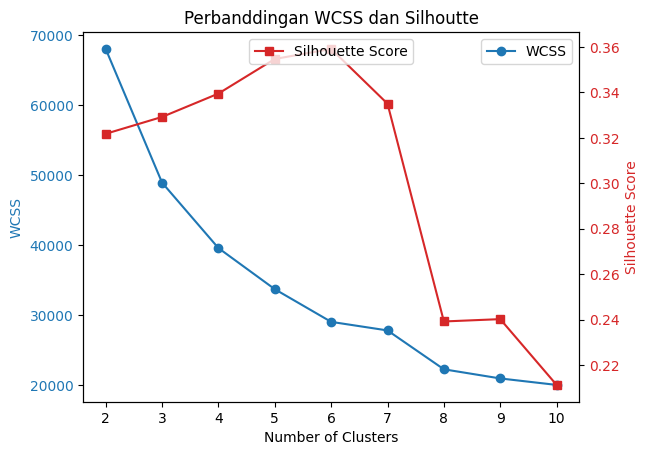

In [76]:
k = range(2,11)

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('WCSS', color=color)
ax1.plot(k, wcss, marker='o', color=color, label="WCSS")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc="upper right")

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(k, scores, marker='s', color=color, label="Silhouette Score")
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc="upper center")

plt.title("Perbanddingan WCSS dan Silhoutte")
plt.show()

#### Knee Elbow untuk Menentukan K Optimal

Elbow (optimal k) berdasarkan WCSS: 4


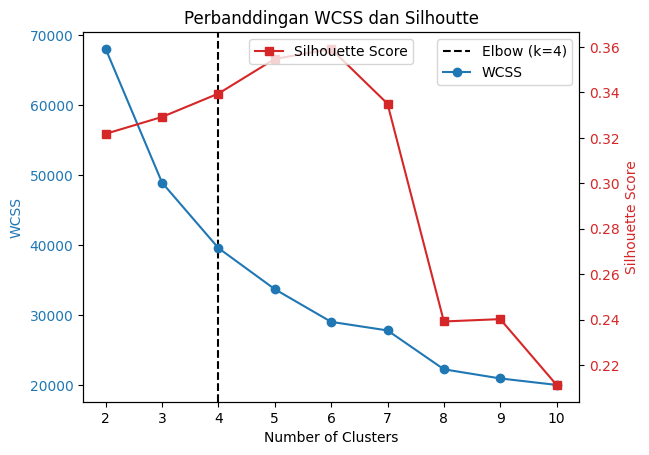

In [77]:
from kneed import KneeLocator

kl = KneeLocator(k, wcss, curve="convex", direction="decreasing")
k_optimal = kl.knee

print("Elbow (optimal k) berdasarkan WCSS:", k_optimal)

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('WCSS', color=color)
ax1.axvline(k_optimal, color='black', linestyle='--', label=f"Elbow (k={k_optimal})")
ax1.plot(k, wcss, marker='o', color=color, label="WCSS")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc="upper right")

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(k, scores, marker='s', color=color, label="Silhouette Score")
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc="upper center")

plt.title("Perbanddingan WCSS dan Silhoutte")
plt.show()


#### Hasil KMeans

c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Rata rata tiap cluster: 



,Jumlah_Transaksi,Total_Amount,Avg_Amount,Max_Amount,Mean_AccountBalance,Umur
cluster,,,,,,
0,-0.039337,-0.032201,-0.031743,-0.032072,-0.010718,-0.091993
1,-0.039337,-0.048735,-0.048288,-0.048607,0.000494,0.031099
2,-0.039337,14.806457,14.816843,14.807043,0.654434,0.616331
3,24.165143,0.316292,0.021782,0.236628,0.340296,-0.085981


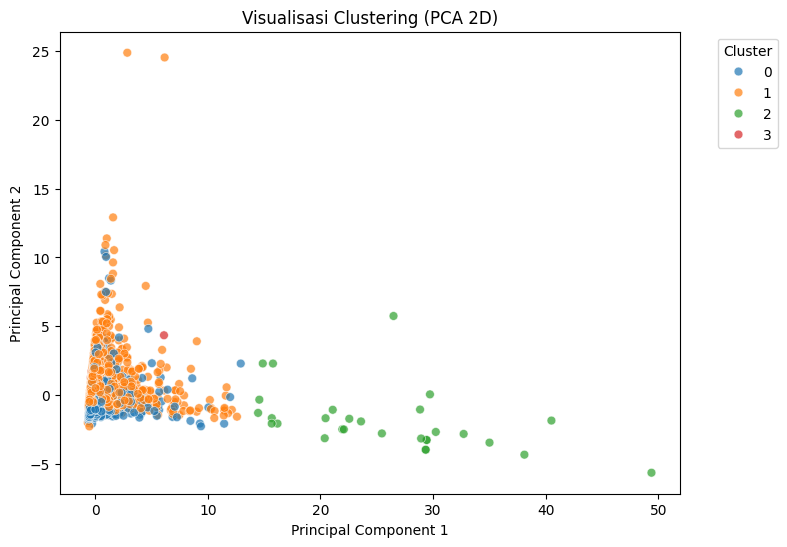

In [82]:
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42)
labels = kmeans_final.fit_predict(df_reduced)

df_num['cluster'] = kmeans_final.fit_predict(df_num)
cluster_summary = df_num.groupby('cluster').mean()
print("Rata rata tiap cluster: \n")

pd.options.display.float_format = '{:.2f}'.format  
cols_to_show = ['Jumlah_Transaksi', 'Total_Amount', 'Avg_Amount', 'Max_Amount', 'Mean_AccountBalance', 'Umur']
display(cluster_summary[cols_to_show].style.background_gradient(cmap='coolwarm').set_caption('Rata-rata Tiap Cluster'))

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=df_reduced[:,0], y=df_reduced[:,1],
    hue=kmeans_final.labels_,
    palette='tab10',
    s=40, alpha=0.7
)
plt.title('Visualisasi Clustering (PCA 2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()